# Standalone Fishbone-Moncrief C Code

We start with the NRPy+ expressions generated in the [Tutorial-FishboneMoncriefID](Tutorial-FishboneMoncriefID.ipynb), and output them to the C file "FishboneMoncriefID/FMstandalone.h".

Further, $\Gamma = \alpha u^0$ is given by (as shown [here](Tutorial-u0_smallb_Poynting-Cartesian.ipynb)):
$$
\Gamma = \alpha u^0 = \sqrt{\frac{1}{1 - \gamma_{ij}v^i_{(n)}v^j_{(n)}}}.
$$

In [1]:
import sympy as sp
from outputC import *
import indexedexp as ixp
import finite_difference as fin
import FishboneMoncriefID.FishboneMoncriefID as fmid

# Step 1: Set up the Fishbone-Moncrief initial data. This sets all the ID gridfunctions.
fmid.FishboneMoncriefID("Spherical")

gammaDD = ixp.zerorank2()

DIM = 3
for i in range(DIM):
    for j in range(DIM):
        if i<=j:
            gammaDD[i][j] = fmid.IDgammaDD[i][j]
        else:
            gammaDD[i][j] = fmid.IDgammaDD[j][i]

# gamma_{ij} v^i_{(n)} v^j_{(n)}
Gammacontraction = sp.sympify(0)
for i in range(DIM):
    for j in range(DIM):
        Gammacontraction += gammaDD[i][j] * fmid.IDValencia3velocityU[i] * fmid.IDValencia3velocityU[j]

Gammafactor = sp.sqrt(1 / (1 - Gammacontraction))

# -={ F-M quantities: Generate C code from expressions and output to file }=-
FishboneMoncrief_to_print = [\
                     lhrh(lhs="alpha",rhs=fmid.IDalpha),\
                     lhrh(lhs="betaU0",rhs=fmid.IDbetaU[0]),\
                     lhrh(lhs="betaU1",rhs=fmid.IDbetaU[1]),\
                     lhrh(lhs="betaU2",rhs=fmid.IDbetaU[2]),\
                     lhrh(lhs="Gammafactor",rhs=Gammafactor),\
                     lhrh(lhs="Gamma_times_ValenciavU0",rhs=Gammafactor*fmid.IDValencia3velocityU[0]),\
                     lhrh(lhs="Gamma_times_ValenciavU1",rhs=Gammafactor*fmid.IDValencia3velocityU[1]),\
                     lhrh(lhs="Gamma_times_ValenciavU2",rhs=Gammafactor*fmid.IDValencia3velocityU[2])
                     ]

fin.FD_outputC("FishboneMoncriefID/FM_standalone.h",FishboneMoncrief_to_print,params="outCverbose=False,CSE_enable=False")

Wrote to file "FishboneMoncriefID/FM_standalone.h"


In [22]:
%%writefile FishboneMoncriefID/FM_standalone.c

#include "stdio.h"
#include "stdlib.h"
#include "math.h"

const double a = 0.9375;
const double M = 1.0;
const double r_at_max_density = 12.0;
const double r_in = 6.0;

int main(int argc, const char *argv[]) {

    // Step 0a: Read command-line input, error out if nonconformant
    double xx0,xx1,xx2;
/*
    if(argc != 4) {
        printf("Error: Expected three command-line arguments: ./FM_standalone r theta phi\n");
        exit(1);
    }
    xx0 = strtod(argv[1],NULL);
    xx1 = strtod(argv[2],NULL);
    xx2 = strtod(argv[3],NULL);
*/
    
//    printf("# Output: r,th,ph, alpha, betaU0, betaU1, betaU2, Gamma, Gamma*vValenciaU0, Gamma*vValenciaU1, Gamma*vValenciaU2\n");
    for(double xx0=1.6;xx0<50.0;xx0+=0.2) {
        xx1 = M_PI/2.0;
        xx2 = 0.0;
        double alpha,betaU0,betaU1,betaU2,Gammafactor,Gamma_times_ValenciavU0,Gamma_times_ValenciavU1,Gamma_times_ValenciavU2;
#include "FM_standalone.h"
        if(xx0 < r_in) {
            Gammafactor = 1.0;
            Gamma_times_ValenciavU0 = Gamma_times_ValenciavU1 = Gamma_times_ValenciavU2 = 0.0;
        }
        printf("%e %e %e %.15e %.15e %.15e %.15e %.15e %.15e %.15e %.15e\n",
               xx0,xx1,xx2,
               alpha,betaU0,betaU1,betaU2,
               Gammafactor,
               Gamma_times_ValenciavU0,
               Gamma_times_ValenciavU1,
               Gamma_times_ValenciavU2);
    }   
    return 0;
}

Overwriting FishboneMoncriefID/FM_standalone.c


In [23]:
!gcc -O2 FishboneMoncriefID/FM_standalone.c -o FM_standalone -lm

In [24]:
!./FM_standalone > out.txt

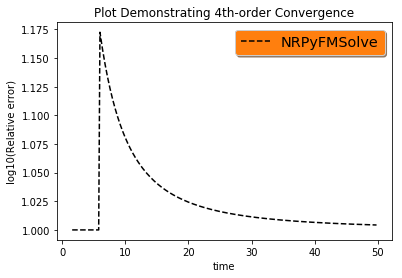

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
import mpmath as mp
import csv

def file_reader(filename):
    with open(filename) as file:
        reader = csv.reader(file, delimiter=" ")
        data  = list(zip(*reader))
        # data is a tuple of strings. Tuples are immutable, and we need to perform math on
        #   the data, so here we convert tuple to lists of floats:
        data0 = []
        dataGamma = []
        dataGammav1 = []
        dataGammav3 = []
        for i in range(len(data[0])):
            data0.append(      float(data[0][i]))
            dataGamma.append(  float(data[7][i]))
            dataGammav1.append(float(data[8][i]))
            dataGammav3.append(float(data[10][i]))
        return data0,dataGamma,dataGammav1,dataGammav3
    
r,Gamma,Gammav1,Gammav3 = file_reader('out.txt')

# https://matplotlib.org/gallery/text_labels_and_annotations/legend.html#sphx-glr-gallery-text-labels-and-annotations-legend-py        
fig, ax = plt.subplots()

plt.title("Plot Demonstrating 4th-order Convergence")
plt.xlabel("time")
plt.ylabel("log10(Relative error)")

ax.plot(r, Gamma, 'k--', label='NRPyFMSolve')
legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')
legend.get_frame().set_facecolor('C1')
plt.show()